# EXAMEN PRIMER PARCIAL
 ## **Mateo Serrato Ascencio**

# Parte 1/3



## 1.1 Construye una Bolsa de Palabras Binaria, normalízala con L2 y evalúa con SVM.

In [13]:
#Importamos librerías
import os 
import re
from collections import Counter

test_folder = "es_test"
labels_file_test = os.path.join(test_folder, "truth.txt")
train_folder = "es_train" #ruta de train
labels_file = os.path.join(train_folder, "truth.txt") #ruta al archivo de labels de train

documentos = [] #almacenamos documentos
generos = [] #almacenamos etiquetas de género
documentos_test = []
generos_test = []

# Leemos las etiquetas
with open(labels_file, 'r', encoding='utf-8') as f:
    for linea in f:
        linea = linea.strip()
        doc_id, genero, _ = linea.split(":::")  # ignoramos el país
        doc_path = os.path.join(train_folder, doc_id + '.xml')

        # Abrimos el archivo XML
        with open(doc_path, 'r', encoding='utf-8') as doc_file:
            contenido_xml = doc_file.read()

            # Extraemos todos los textos dentro de CDATA de cada <document>
            textos = re.findall(r'<!\[CDATA\[(.*?)\]\]>', contenido_xml, re.DOTALL)

            # Unimos todos los tuits en un solo texto
            texto = " ".join(textos)

        # Guardamos el texto y la etiqueta
        documentos.append(texto)
        generos.append(genero)

        # Cargar XMLs de test
for linea in open(labels_file_test, 'r', encoding='utf-8'):
    linea = linea.strip()
    doc_id, genero, _ = linea.split(":::")
    doc_path = os.path.join(test_folder, doc_id + '.xml')

    with open(doc_path, 'r', encoding='utf-8') as f:
        contenido_xml = f.read()
        textos = re.findall(r'<!\[CDATA\[(.*?)\]\]>', contenido_xml, re.DOTALL)
        texto = " ".join(textos)

    documentos_test.append(texto)
    generos_test.append(genero)

print("Cantidad de documentos:", len(documentos))
print("Cantidad de labels:", len(generos))

print("Cantidad de documentos test:", len(documentos_test))
print("Cantidad de labels test:", len(generos_test))

Cantidad de documentos: 4200
Cantidad de labels: 4200
Cantidad de documentos test: 2800
Cantidad de labels test: 2800


In [14]:
import nltk
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
corpus_palabras = []
for tweet in documentos:
    corpus_palabras+= tokenizer.tokenize(tweet)
fdist = nltk.FreqDist(corpus_palabras)


In [44]:
import numpy as np
def sort_freq(fdist):
    aux = [(fdist[key], key) for key in fdist]
    aux.sort(reverse=True) 
    return aux

V = sort_freq(fdist)
V = V[:10000]


In [45]:
len(V)

10000

In [46]:
dict_indices = dict()
cont = 0
for weight, word in V:
    dict_indices[word] = cont
    cont += 1

In [47]:
# CONSTRUIMOS BOW BINARIA
import numpy as np


def build_bow(tr_text,V, dict_indices):
    tokenizer = TweetTokenizer()
    
    # Crear matriz vacía
    M = np.zeros((len(tr_text), len(V)), dtype=int)
    
    # Recorremos cada documento
    
    for i, tr in enumerate(tr_text):
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(tr.lower()))
        for word in fdist_doc:
            if word in dict_indices:  #Si la palabra está en el vocabulario
                M[i, dict_indices[word]] = 1
        
    

    return M


In [49]:
BOW_tr = build_bow(documentos,V,dict_indices)

In [50]:
BOW_tr.shape

(4200, 10000)

In [51]:
#Construimos la BOW para validar en test
BOW_te = build_bow(documentos_test, V,dict_indices)

In [52]:
#construimos el normalizador con l2 y lo ajustamos en train
from sklearn import preprocessing
normalizer = preprocessing.Normalizer(norm='l2')

BOW_tr_norm = normalizer.fit_transform(BOW_tr)

In [53]:
#se lo aplicamos tmb a test
BOW_te_norm = normalizer.transform(BOW_te)

In [54]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

#Convertimos etiquetas a numeros (hombre y mujer) 1 mujer, 0 hombre
generos_num = [0 if g=='male' else 1 for g in generos]
generos_test_num = [0 if g=='male' else 1 for g in generos_test]

In [55]:
parameters = {'C': [0.12, 0.25, 0.5, 1, 2, 4]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)
grid = GridSearchCV(estimator=svr, param_grid=parameters, scoring='f1_macro', n_jobs=-1, cv=5)


In [ ]:
#ENTRENAMOS CON TRAIN
grid.fit(BOW_tr_norm, generos_num)

GridSearchCV(cv=5, estimator=LinearSVC(class_weight='balanced', max_iter=10000),
             n_jobs=-1, param_grid={'C': [0.12, 0.25, 0.5, 1, 2, 4]},
             scoring='f1_macro')

In [73]:
#PREDECIMOS EN TEST
y_pred_bow = grid.predict(BOW_te_norm)

In [74]:
# --- Parte 1.1: BoW Binaria - métricas ---
p_bow, r_bow, f_bow, _ = precision_recall_fscore_support(generos_test_num, y_pred_bow, average='macro')
print("Precision (BoW binaria):", p_bow)
print("Recall (BoW binaria):", r_bow)
print("F1-score (BoW binaria):", f_bow)

print("\nMatriz de confusión (BoW binaria):")
print(confusion_matrix(generos_test_num, y_pred_bow))

print("\nReporte completo (BoW binaria):")
print(classification_report(generos_test_num, y_pred_bow, target_names=['male','female']))


Precision (BoW binaria): 0.7992722280212379
Recall (BoW binaria): 0.7839285714285714
F1-score (BoW binaria): 0.7811231226365594

Matriz de confusión (BoW binaria):
[[1256  144]
 [ 461  939]]

Reporte completo (BoW binaria):
              precision    recall  f1-score   support

        male       0.73      0.90      0.81      1400
      female       0.87      0.67      0.76      1400

    accuracy                           0.78      2800
   macro avg       0.80      0.78      0.78      2800
weighted avg       0.80      0.78      0.78      2800



 ## 1.2 Construye una Bolsa de Palabras con pesado TF-IDF, normalízala con L2 y
evalúa con SVM.

In [66]:
from collections import defaultdict
df = defaultdict(int)
tokenizer = TweetTokenizer()

for doc in documentos:  # solo train
    tokens = set(tokenizer.tokenize(doc.lower()))  # contar cada palabra solo 1 vez por documento
    for t in tokens:
        if t in dict_indices:  # solo palabras del vocabulario
            df[t] += 1


Para un término $t$ en un documento $d$:

$$
\text{TF-IDF}(t,d) = \text{TF}(t,d) \times \log \frac{N}{DF(t)}
$$

donde:  

- $\text{TF}(t,d)$ es la frecuencia del término en el documento  
- $DF(t)$ es el número de documentos en los que aparece el término  
- $N$ es el número total de documentos del train

In [67]:
def build_BOW_tfidf(documents, V, dict_indices, df, N):
    M = np.zeros((len(documents), len(V)), dtype=float)
    tokenizer = TweetTokenizer()
    
    for i, doc in enumerate(documents):
        fdist_doc = nltk.FreqDist(tokenizer.tokenize(doc.lower()))
        for word, freq in fdist_doc.items():
            if word in dict_indices:
                # TF-IDF con logaritmo
                M[i, dict_indices[word]] = freq * np.log(N / df[word])
    return M


In [68]:

N_docs = len(documentos)
N_docs

4200

In [69]:
BOW_tr_tfidf = build_BOW_tfidf(documentos, V, dict_indices, df, N_docs)
BOW_te_tfidf = build_BOW_tfidf(documentos_test, V, dict_indices, df, N_docs)

In [70]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='l2')

BOW_tr_tfidf_norm = normalizer.fit_transform(BOW_tr_tfidf)
BOW_te_tfidf_norm = normalizer.transform(BOW_te_tfidf)

In [75]:
# --- Parte 1.2: BoW TF-IDF - entrenamiento y métricas ---
parameters = {'C': [0.12, 0.25, 0.5, 1, 2, 4]}
svr = svm.LinearSVC(class_weight='balanced', max_iter=10000)
grid_tfidf = GridSearchCV(estimator=svr, param_grid=parameters, scoring='f1_macro', n_jobs=-1, cv=5)

# Entrenar con TF-IDF normalizado
grid_tfidf.fit(BOW_tr_tfidf_norm, generos_num)

# Predecir en test
y_pred_tfidf = grid_tfidf.predict(BOW_te_tfidf_norm)

# Métricas
p_tfidf, r_tfidf, f_tfidf, _ = precision_recall_fscore_support(generos_test_num, y_pred_tfidf, average='macro')
print("Precision (TF-IDF):", p_tfidf)
print("Recall (TF-IDF):", r_tfidf)
print("F1-score (TF-IDF):", f_tfidf)

print("\nMatriz de confusión (TF-IDF):")
print(confusion_matrix(generos_test_num, y_pred_tfidf))

print("\nReporte completo (TF-IDF):")
print(classification_report(generos_test_num, y_pred_tfidf, target_names=['male','female']))


Precision (TF-IDF): 0.7866894197952219
Recall (TF-IDF): 0.7860714285714285
F1-score (TF-IDF): 0.7859560796475141

Matriz de confusión (TF-IDF):
[[1133  267]
 [ 332 1068]]

Reporte completo (TF-IDF):
              precision    recall  f1-score   support

        male       0.77      0.81      0.79      1400
      female       0.80      0.76      0.78      1400

    accuracy                           0.79      2800
   macro avg       0.79      0.79      0.79      2800
weighted avg       0.79      0.79      0.79      2800



"""Al usar TF-IDF con logaritmo, el desempeño es ligeramente menor que con BoW binaria.
 Esto puede deberse a la naturaleza corta de los tweets."""

Propón alguna forma de calcular TF-IDF. Una opción simple es multiplicar la
frecuencia del término en el documento y dividirla entre el número de
documentos en training en que aparece dicho término.

Existen muchas otras variantes de TFIDF: https://es.wikipedia.org/wiki/Tf-idf
1.3 Presenta una tabla comparativa del desempeño obtenido de BoW Binaria
vs BoW TFIDF.

## 1.3 Presenta una tabla comparativa del desempeño obtenido de BoW Binaria vs BoW TFIDF.

In [77]:
from IPython.display import Markdown

# --- Parte 1.3: Tabla comparativa BoW Binaria vs TF-IDF (solo métricas) ---

tabla_comparativa = f"""
| Método        | Precision | Recall | F1-score |
|---------------|-----------|--------|----------|
| BoW Binaria   | {p_bow:.4f}    | {r_bow:.4f} | {f_bow:.4f} |
| BoW TF-IDF    | {p_tfidf:.4f}    | {r_tfidf:.4f} | {f_tfidf:.4f} |
"""

# Mostrar la tabla en Markdown
display(Markdown(tabla_comparativa))



| Método        | Precision | Recall | F1-score |
|---------------|-----------|--------|----------|
| BoW Binaria   | 0.7993    | 0.7839 | 0.7811 |
| BoW TF-IDF    | 0.7867    | 0.7861 | 0.7860 |


# PARTE 2/3

 ## 2.1 Grafica la constelación de las 1000 mejores palabras según DOR del dataset.

In [78]:
#cuantas veces aparece el término en el documento multiplicado por el tamaño del vocabulario total/vocabulario en el tuit 
def compute_dor(TR):
    num_docs, vocab_size = TR.shape
    # Creamos matriz con filas = palabras, columnas = documentos
    DTR = np.zeros((vocab_size, num_docs), dtype=np.float64)

    for i, doc in enumerate(TR):
        non_zero_positions = np.nonzero(doc)[0]
        tam_v = len(non_zero_positions)
        if tam_v == 0:
            tam_v = 1
        for term in non_zero_positions:
            # DTR[palabra, documento]
            DTR[term, i] = (max(doc[term],1)) * np.log10(vocab_size/tam_v)

    return DTR


In [79]:
DOR_base = compute_dor(BOW_tr)

In [80]:
DOR_base.shape

(10000, 4200)

In [81]:
from sklearn import preprocessing
DOR_base = preprocessing.normalize(DOR_base,norm='l2')

In [82]:
from sklearn.feature_selection import SelectKBest, chi2

feats = SelectKBest(chi2, k=1000)
feats.fit(BOW_tr,generos)
best = feats.get_support(indices=True)
best

array([  38,   42,   44,   65,   66,   75,   80,   81,   97,   98,  108,
        113,  114,  116,  118,  122,  126,  130,  131,  134,  139,  142,
        147,  148,  149,  165,  169,  173,  175,  177,  185,  190,  191,
        192,  197,  203,  204,  207,  208,  211,  214,  219,  220,  221,
        227,  229,  237,  238,  239,  240,  242,  243,  248,  256,  257,
        258,  259,  264,  265,  268,  269,  275,  281,  285,  287,  290,
        294,  295,  296,  300,  302,  307,  313,  314,  322,  323,  328,
        333,  336,  340,  342,  349,  350,  351,  355,  361,  370,  377,
        385,  386,  394,  395,  396,  399,  405,  407,  412,  413,  414,
        416,  420,  422,  423,  424,  427,  428,  429,  431,  433,  439,
        443,  452,  455,  458,  461,  467,  470,  478,  479,  483,  485,
        487,  491,  499,  500,  506,  511,  514,  520,  528,  531,  532,
        534,  537,  538,  541,  545,  546,  549,  550,  552,  560,  562,
        564,  582,  589,  592,  594,  603,  604,  6

In [83]:
dict_indices_invertido = {}
for w in dict_indices:
    dict_indices_invertido[dict_indices[w]] = w

In [84]:
dict_indices_invertido

{0: 'de',
 1: ',',
 2: '.',
 3: 'que',
 4: 'la',
 5: '!',
 6: 'y',
 7: 'a',
 8: 'en',
 9: 'el',
 10: 'no',
 11: 'es',
 12: '?',
 13: 'los',
 14: '...',
 15: 'un',
 16: 'con',
 17: 'se',
 18: 'por',
 19: '"',
 20: 'me',
 21: 'lo',
 22: 'para',
 23: 'del',
 24: ':',
 25: 'las',
 26: 'una',
 27: '…',
 28: 'mi',
 29: 'te',
 30: 'al',
 31: 'más',
 32: 'como',
 33: 'El',
 34: 'si',
 35: 'q',
 36: 'pero',
 37: '-',
 38: '(',
 39: 'No',
 40: 'La',
 41: 'su',
 42: '😂',
 43: 'ya',
 44: ')',
 45: 'Y',
 46: '¿',
 47: 'le',
 48: 'Que',
 49: 'todo',
 50: 'tu',
 51: 'Me',
 52: 'vía',
 53: 'yo',
 54: 'o',
 55: 'esta',
 56: 'este',
 57: '¡',
 58: 'hay',
 59: 'son',
 60: 'ser',
 61: 'cuando',
 62: 'está',
 63: 'A',
 64: 'mejor',
 65: '😍',
 66: 'día',
 67: 'eso',
 68: '..',
 69: 'todos',
 70: 'muy',
 71: 'nos',
 72: 'En',
 73: 'bien',
 74: 'sin',
 75: 'vida',
 76: 'tiene',
 77: 'ha',
 78: 'hoy',
 79: 'ver',
 80: 'siempre',
 81: '❤',
 82: 'nada',
 83: '@YouTube',
 84: 'porque',
 85: 'qué',
 86: 'Los',
 87

In [85]:

target_words = [dict_indices_invertido[index] for index in best]
t_words = target_words # t_words es una lista de las mil palabras mejores segun Chi2
target_matrix = np.array([DOR_base[dict_indices[word]] for word in t_words])
target_matrix.shape

(1000, 4200)

In [86]:
from sklearn.manifold import TSNE  
reduced_matrix = TSNE(n_components=2).fit_transform(target_matrix) # reduced_matrix aqui estan las mil mejores palabras reducidas a 2D

In [87]:
reduced_matrix

array([[-1.2717674, -4.1652274],
       [ 2.622232 , 10.70889  ],
       [-1.2710029, -4.192779 ],
       ...,
       [ 3.100514 ,  7.130409 ],
       [ 1.0335239, -3.0867507],
       [ 1.879757 ,  6.085236 ]], dtype=float32)

In [88]:
reduced_matrix.shape


(1000, 2)

In [89]:
max_x = np.amax(reduced_matrix,axis=0)[0]

In [90]:
max_x

np.float32(9.22306)

In [91]:
max_y = np.amax(reduced_matrix,axis=0)[1]

In [92]:
max_y 

np.float32(17.219833)

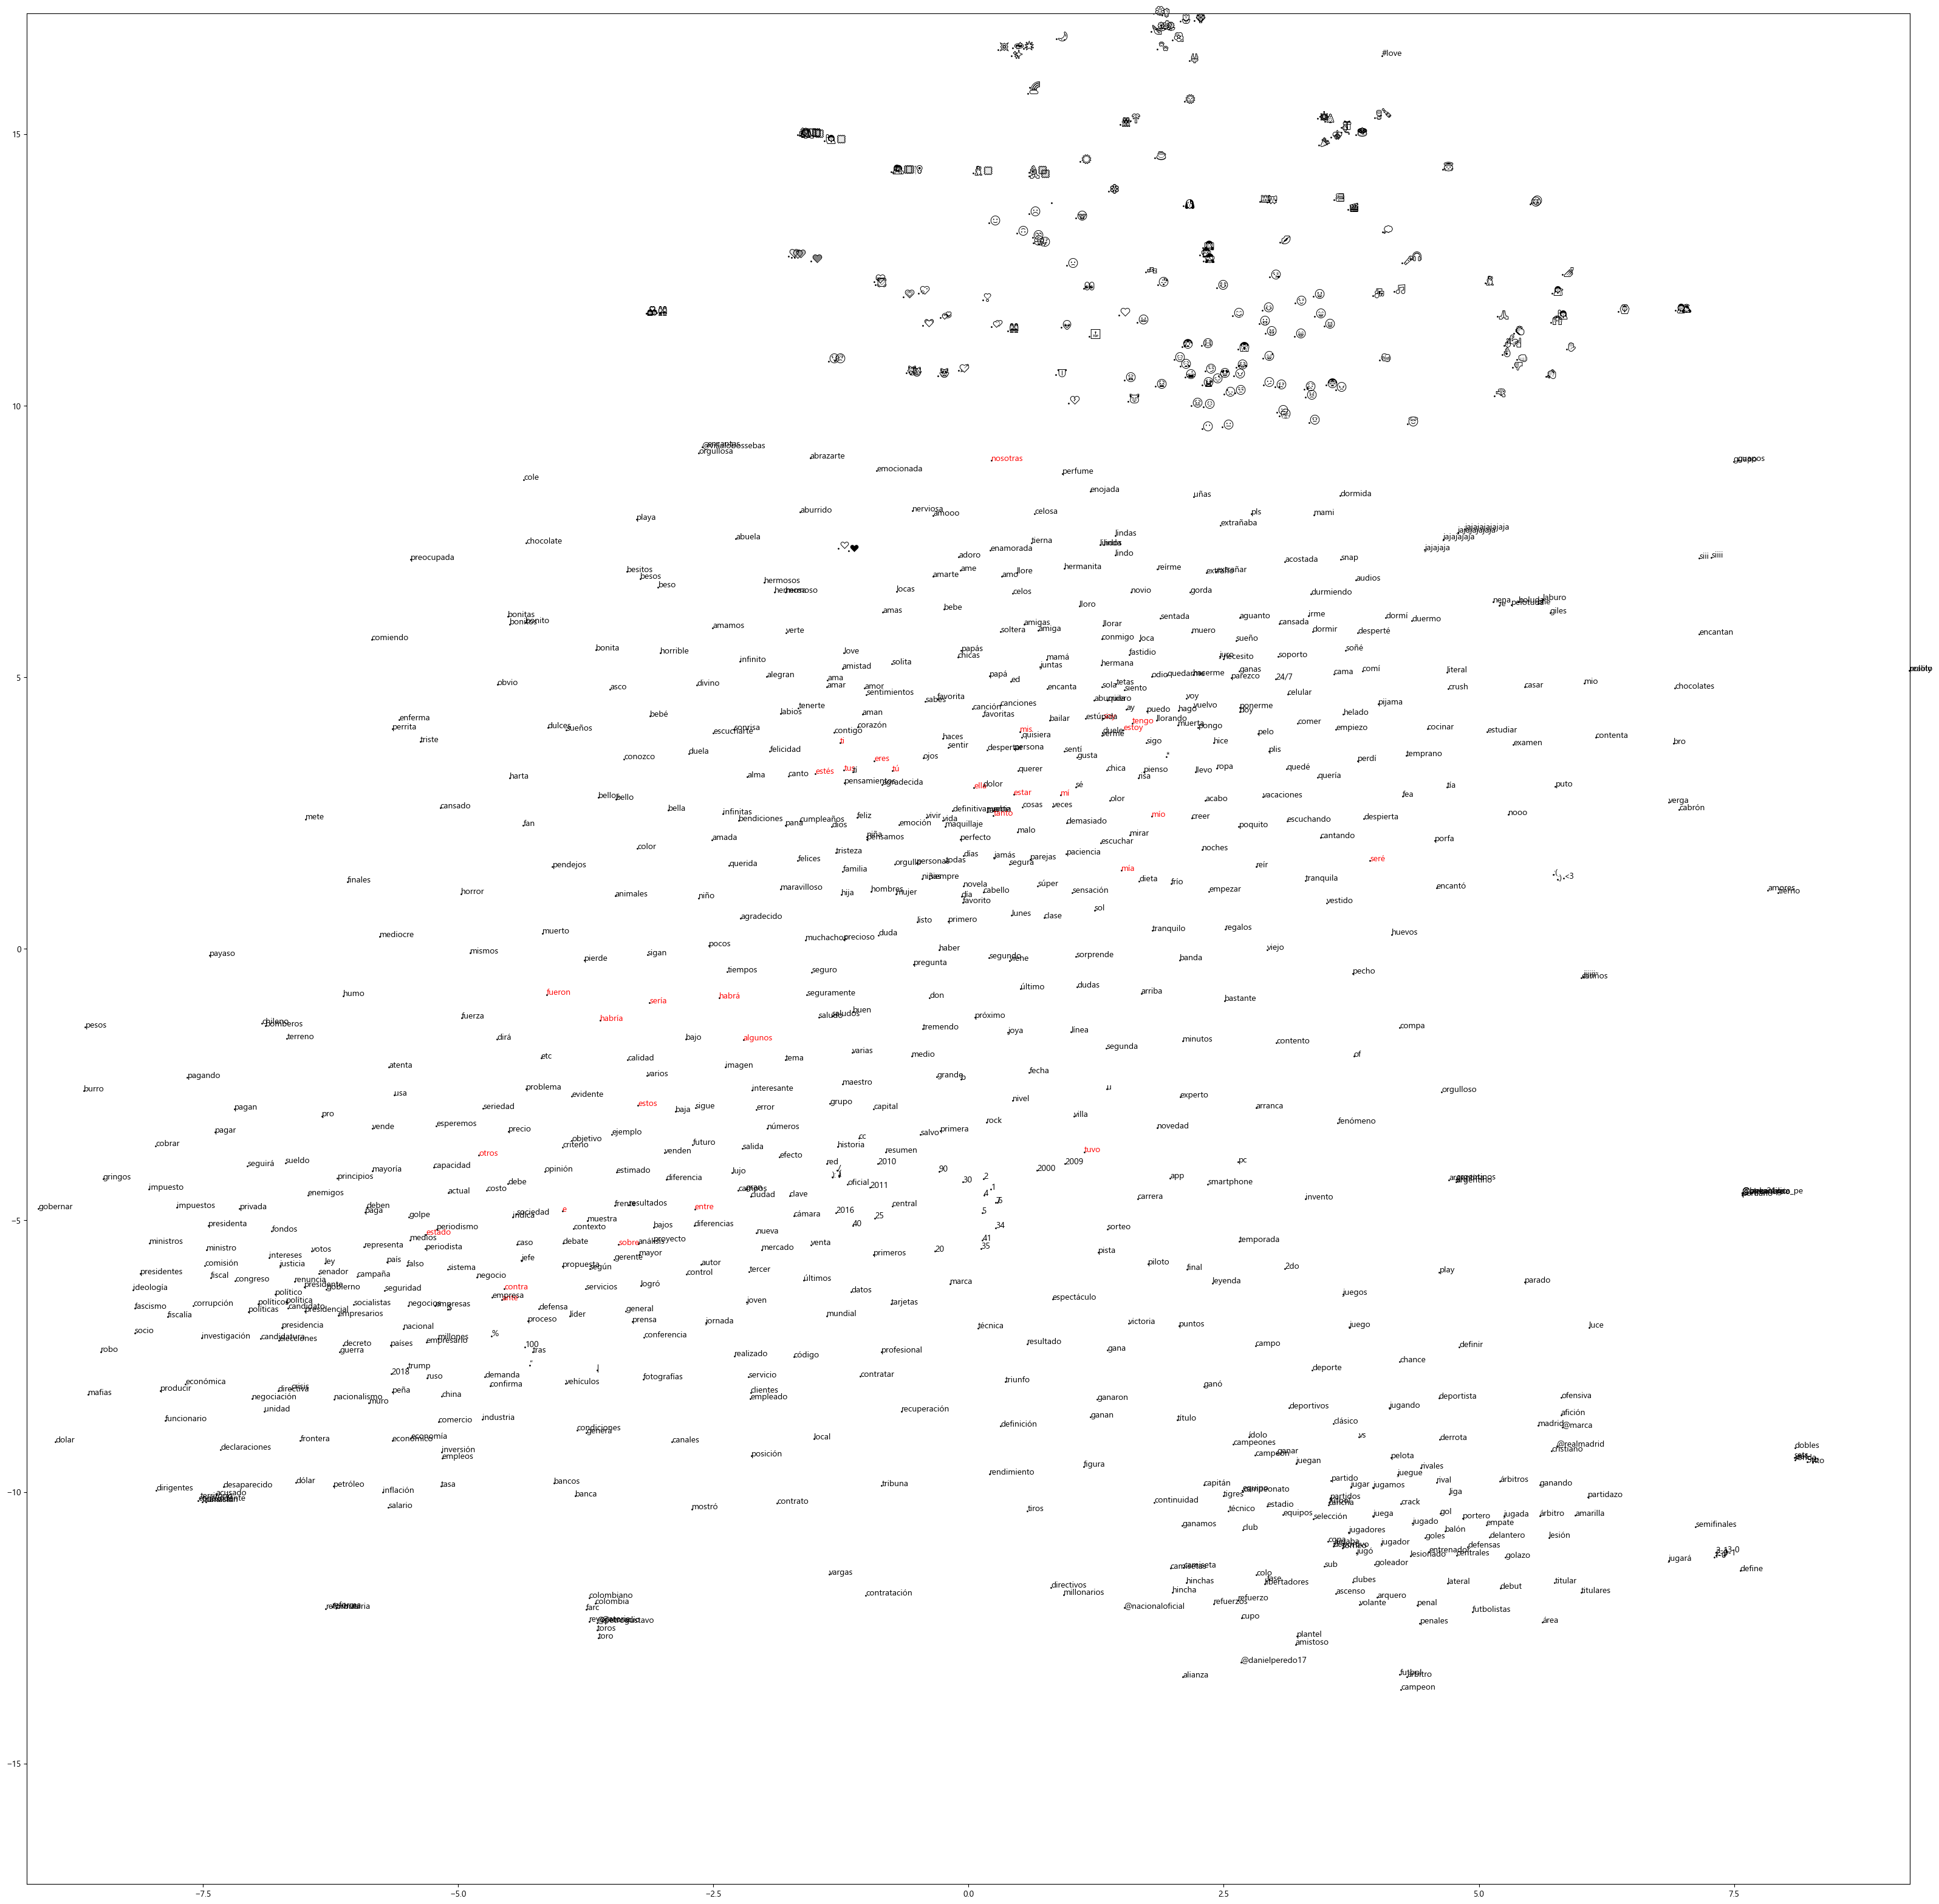

In [96]:

import matplotlib.pyplot as plt 
from matplotlib import rcParams
# Cambiar la fuente a una que soporte emojis
rcParams['font.family'] = 'Segoe UI Emoji'  # Windows
# rcParams['font.family'] = 'Noto Color Emoji'  # Linux/Mac

plt.figure(figsize=(40,40),dpi=100)
plt.xlim((-max_x,max_x))
plt.ylim((-max_y,max_y))
plt.scatter(reduced_matrix[:,0],reduced_matrix[:,1],1, color = 'black')

from nltk.corpus import stopwords
sw = set(stopwords.words('spanish'))
#escribir nombre de la palabra
for idx, word in enumerate(t_words[:]):
    #coords para pintar la palabra
    x = reduced_matrix[idx, 0]
    y = reduced_matrix[idx, 1]
    

    if word in sw:
        plt.annotate(word,(x,y),color = 'red')
    else:
        plt.annotate(word,(x,y),color = 'black')
    

## 2.2 Construye una nube de palabras (wordcloud) con las 100 mejores palabras del dataset.


In [ ]:
#AHORA HAGAMOS UN WORDCLOUD DE LAS PALABRAS MÁS IMPORTANTES EXTRAIDAS DE LOS DOCUMENTOS USANDO CHI2
k = 100 #top 100 palabras
feats = SelectKBest(chi2, k=k)
feats.fit(BOW_tr_norm, generos_num)

In [101]:
best_indices = feats.get_support(indices=True)
scores = feats.scores_[best_indices]  # importancias de Chi2
target_words = [dict_indices_invertido[i] for i in best_indices]


In [102]:
# Crear diccionario palabra -> score
word_importance = {}  # Creamos un diccionario vacío
for word, score in zip(target_words, scores):
    word_importance[word] = score  # Asignamos cada palabra como clave y su score como valor

In [103]:
# FILTRAR PALABRAS VÁLIDAS Y STOPWORDS
sw = set(stopwords.words('spanish'))
# Filtrar usando regex y stopwords
word_importance_filtrado = {w: s for w, s in word_importance.items() 
                            if re.match(r'^[a-záéíóüñ]+$', w) and w not in sw}

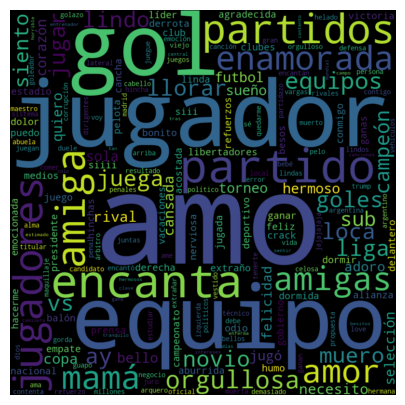

In [104]:
from wordcloud import WordCloud

#CREAR WORDCLOUD
wordcloud = WordCloud(width=800, height=800, background_color='black').generate_from_frequencies(word_importance_filtrado)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#  PARTE 3/3

## 3.1 Programa TCOR (term co-occurrence matrix) como se propone en el paper de Lavelli indicado en este examen.

In [107]:
import numpy as np
from sklearn.feature_selection import chi2, SelectKBest

# Seleccionamos las 1000 palabras más importantes con chi2
k = 1000
feats = SelectKBest(chi2, k=k)
feats.fit(BOW_tr_norm, generos_num)
best_indices = feats.get_support(indices=True)




In [108]:
# Creamos diccionario palabra / índice
target_words = [dict_indices_invertido[i] for i in best_indices]
word_to_idx = {w:i for i,w in enumerate(target_words)}


In [109]:

# Construimos la matriz TCOR
TCOR = np.zeros((k, k), dtype=int)

In [110]:
# Recorremos los documentos y actualizamos co-ocurrencias
for i, doc_vec in enumerate(BOW_tr):
    # Solo consideramos palabras dentro de las top k
    words_in_doc = [j for j in best_indices if doc_vec[j] > 0]
    for wi in words_in_doc:
        for wj in words_in_doc:
            if wi != wj:
                idx_i = word_to_idx[dict_indices_invertido[wi]]
                idx_j = word_to_idx[dict_indices_invertido[wj]]
                TCOR[idx_i, idx_j] += 1

print("TCOR shape:", TCOR.shape)

TCOR shape: (1000, 1000)


In [111]:
TCOR

array([[   0, 1385,  901, ...,   25,   34,   24],
       [1385,    0, 1183, ...,   42,  110,   42],
       [ 901, 1183,    0, ...,   22,   32,   24],
       ...,
       [  25,   42,   22, ...,    0,    1,    1],
       [  34,  110,   32, ...,    1,    0,    3],
       [  24,   42,   24, ...,    1,    3,    0]])

## 3.2  Proyéctalo con t-SNE a dos dimensiones y muestra la constelación de las 1000 mejores palabras en TCOR.

In [112]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [113]:
# Elegimos las 1000 palabras top
top_n = 1000
top_words_tsne = target_words[:top_n]

In [114]:
# Filtramos la matriz TCOR solo para esas palabras
tcorr_top = TCOR[:top_n, :top_n]

In [116]:
# t-SNE a 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=50, max_iter=1000)
reduced_matrix = tsne.fit_transform(tcorr_top)

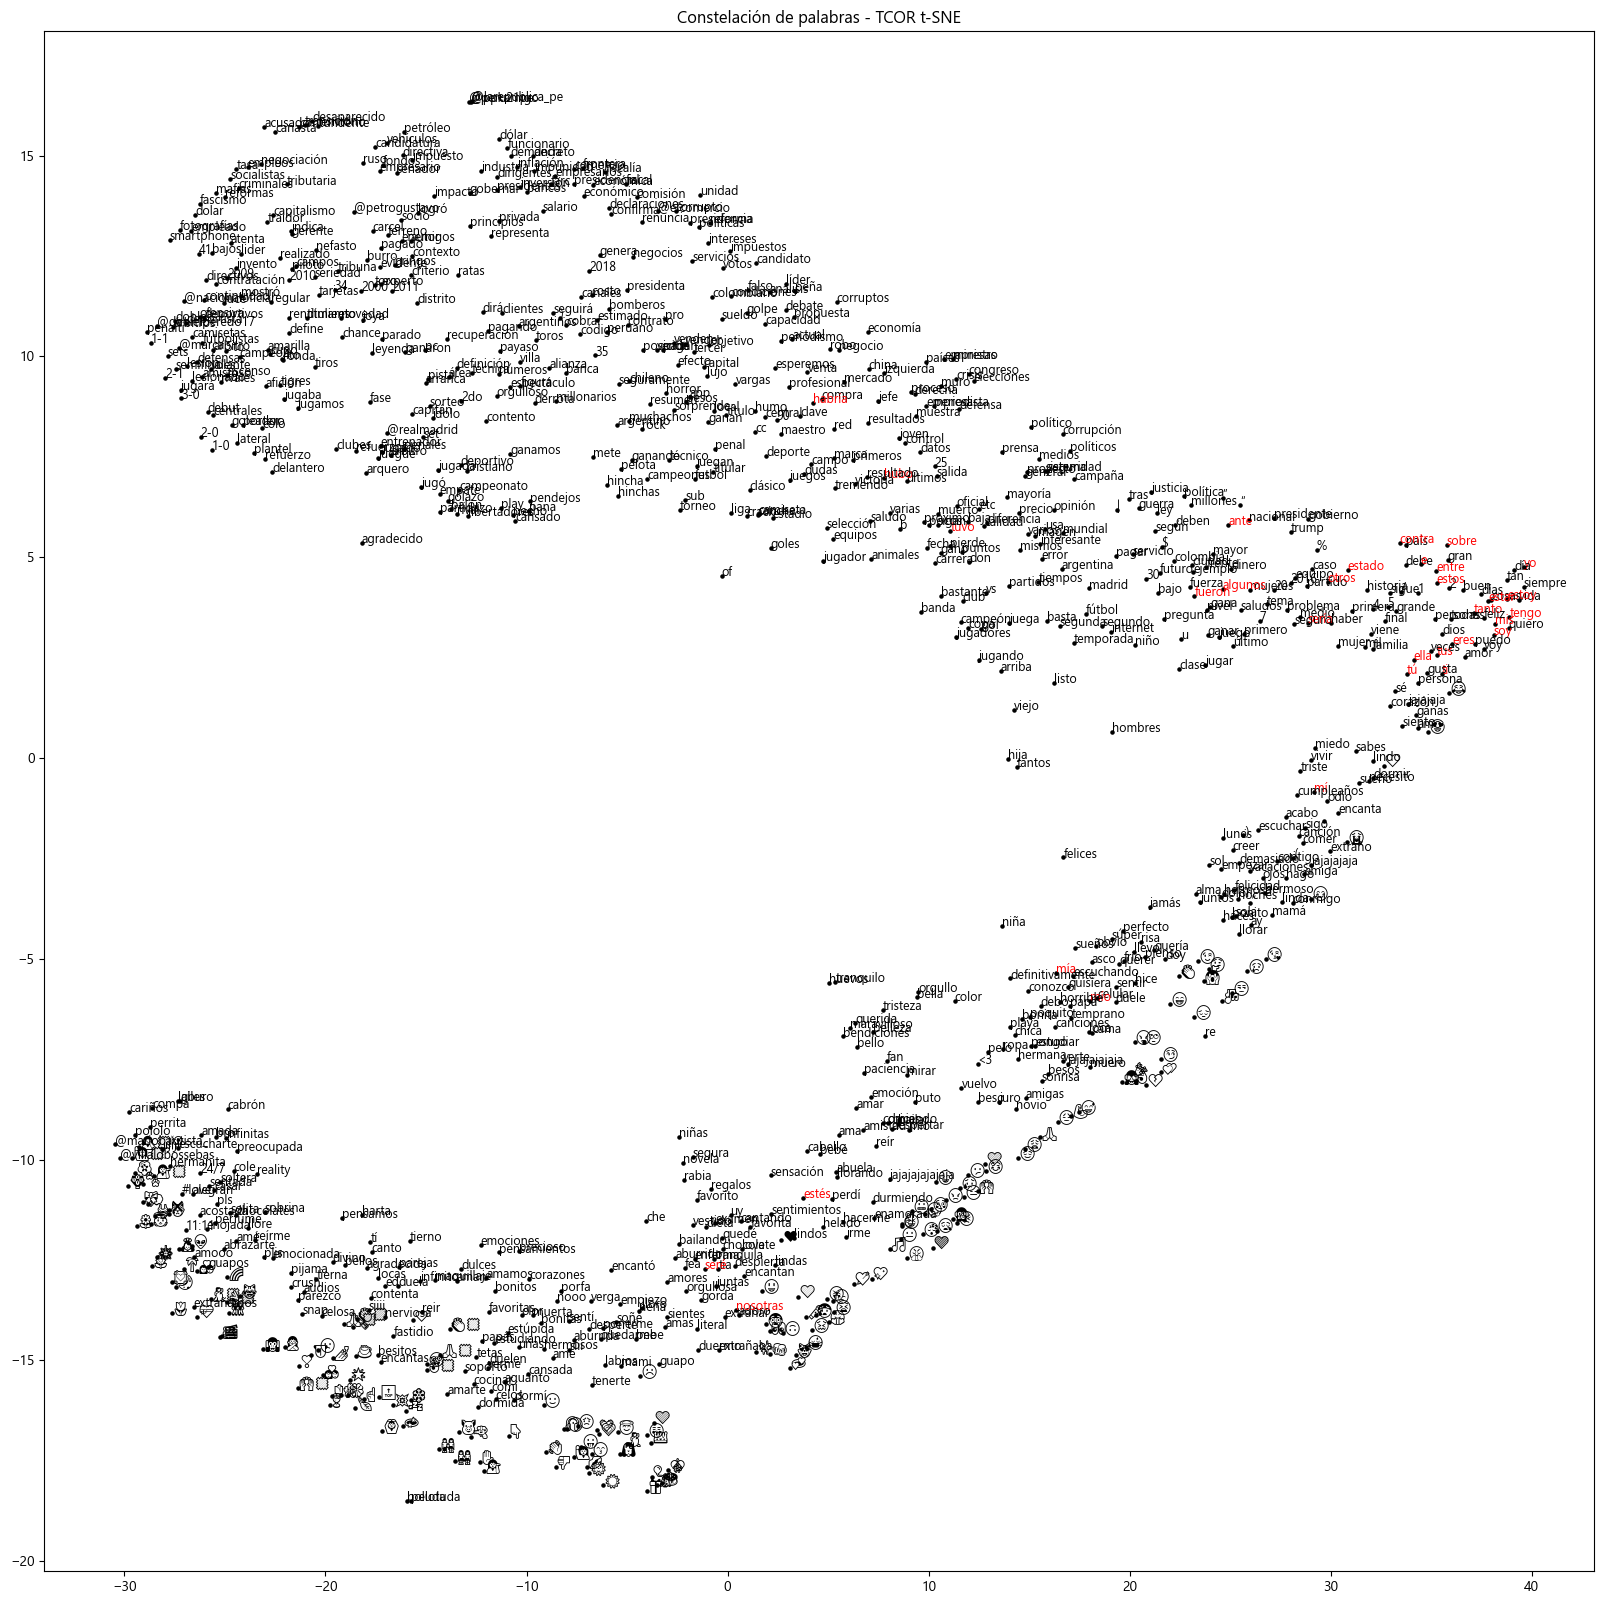

In [118]:
# Graficar
plt.figure(figsize=(20, 20))
plt.scatter(reduced_matrix[:,0], reduced_matrix[:,1], s=5, color='black')

# Añadir etiquetas
sw = set(stopwords.words('spanish'))
for idx, word in enumerate(top_words_tsne):
    x, y = reduced_matrix[idx]
    color = 'red' if word in sw else 'black'
    plt.annotate(word, (x, y), color=color, fontsize=9)

plt.title("Constelación de palabras - TCOR t-SNE")
plt.show()